# Text processing

In [1]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np 
import pandas as pd
from datetime import date
from tqdm.auto import tqdm
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib import cm
from skfin.plot import bar, line

## Loading the FOMC statements 

In [2]:
from skfin.datasets import load_fomc_statements
from skfin.text import show_text
statements = load_fomc_statements(force_reload=False)

INFO:skfin.datasets:logging from cache file: /home/schamponn/dev/projects/skfin/nbs/data/fomc_statements.parquet


In [3]:
show_text(statements)

,last_update,text,voting,release_time,url
release_date,,,,,
2000-05-16,2000-05-16,"Increases in demand have remained in excess of even the rapid pace of productivity-driven gains in potential supply, exerting continued pressure on resources. The Committee is concerned that this disparity in the growth of demand and potential supply will continue, which could foster inflationary imbalances that would undermine the economy's outstanding performance. Against the background of its long-term goals of price stability and sustainable economic growth and of the information already available, the Committee believes the risks are weighted mainly toward conditions that may generate heightened inflation pressures in the foreseeable future. In taking the discount rate action, the Federal Reserve Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, Cleveland, Richmond, and San Francisco. The discount rate is the rate charged depository institutions when they borrow short-term adjustment credit from their district Federal Reserve Banks.",,,https://www.federalreserve.gov/boarddocs/press/general/2000/20000516/
2019-03-20,2019-03-20,"Information received since the Federal Open Market Committee met in January indicates that the labor market remains strong but that growth of economic activity has slowed from its solid rate in the fourth quarter. Payroll employment was little changed in February, but job gains have been solid, on average, in recent months, and the unemployment rate has remained low. Recent indicators point to slower growth of household spending and business fixed investment in the first quarter. On a 12-month basis, overall inflation has declined, largely as a result of lower energy prices; inflation for items other than food and energy remains near 2 percent. On balance, market-based measures of inflation compensation have remained low in recent months, and survey-based measures of longer-term inflation expectations are little changed. Consistent with its statutory mandate, the Committee seeks to foster maximum employment and price stability. In support of these goals, the Committee decided to maintain the target range for the federal funds rate at 2-1/4 to 2-1/2 percent. The Committee continues to view sustained expansion of economic activity, strong labor market conditions, and inflation near the Committee's symmetric 2 percent objective as the most likely outcomes. In light of global economic and financial developments and muted inflation pressures, the Committee will be patient as it determines what future adjustments to the target range for the federal funds rate may be appropriate to support these outcomes. In determining the timing and size of future adjustments to the target range for the federal funds rate, the Committee will assess realized and expected economic conditions relative to its maximum employment objective and its symmetric 2 percent inflation objective. This assessment will take into account a wide range of information, including measures of labor market conditions, indicators of inflation pressures and inflation expectations, and readings on financial and international developments.","Voting for the FOMC monetary policy action were: Jerome H. Powell, Chairman; John C. Williams, Vice Chairman; Michelle W. Bowman; Lael Brainard; James Bullard; Richard H. Clarida; Charles L. Evans; Esther L. George; Randal K. Quarles; and Eric S. Rosengren.",For release at 2:00 p.m. EDT,https://www.federalreserve.gov/newsevents/pressreleases/monetary20190320a.htm


In [4]:
special_days = ['2008-01-22', '2010-05-09', '2020-03-15']

In [5]:
show_text(statements.loc[special_days])

,last_update,text,voting,release_time,url
release_date,,,,,
2008-01-22,2008-01-22,"The Federal Open Market Committee has decided to lower its target for the federal funds rate 75 basis points to 3-1/2 percent. The Committee took this action in view of a weakening of the economic outlook and increasing downside risks to growth. While strains in short-term funding markets have eased somewhat, broader financial market conditions have continued to deteriorate and credit has tightened further for some businesses and households. Moreover, incoming information indicates a deepening of the housing contraction as well as some softening in labor markets. The Committee expects inflation to moderate in coming quarters, but it will be necessary to continue to monitor inflation developments carefully. Appreciable downside risks to growth remain. The Committee will continue to assess the effects of financial and other developments on economic prospects and will act in a timely manner as needed to address those risks.","Voting for the FOMC monetary policy action were: Ben S. Bernanke, Chairman; Timothy F. Geithner, Vice Chairman; Charles L. Evans; Thomas M. Hoenig; Donald L. Kohn; Randall S. Kroszner; Eric S. Rosengren; and Kevin M. Warsh. Voting against was William Poole, who did not believe that current conditions justified policy action before the regularly scheduled meeting next week. Absent and not voting was Frederic S. Mishkin.",For immediate release,https://www.federalreserve.gov/newsevents/press/monetary/20080122b.htm
2010-05-09,2010-05-10,"In response to the reemergence of strains in U.S. dollar short-term funding markets in Europe, the Bank of Canada, the Bank of England, the European Central Bank, the Federal Reserve, and the Swiss National Bank are announcing the reestablishment of temporary U.S. dollar liquidity swap facilities. These facilities are designed to help improve liquidity conditions in U.S. dollar funding markets and to prevent the spread of strains to other markets and financial centers. The Bank of Japan will be considering similar measures soon. Central banks will continue to work together closely as needed to address pressures in funding markets. The Federal Open Market Committee has authorized temporary reciprocal currency arrangements (swap lines) with the Bank of Canada, the Bank of England, the European Central Bank (ECB), and the Swiss National Bank. The arrangements with the Bank of England, the ECB, and the Swiss National Bank will provide these central banks with the capacity to conduct tenders of U.S. dollars in their local markets at fixed rates for full allotment, similar to arrangements that had been in place previously. The arrangement with the Bank of Canada would support drawings of up to \$30 billion, as was the case previously. These swap arrangements have been authorized through January 2011. Further details on these arrangements will be available shortly. Information on the actions that will be taken by other central banks is available at the following websites:",,For release at 9:15 p.m. EDT,https://www.federalreserve.gov/newsevents/press/monetary/20100509a.htm


## TFIDF vectorization 

In order to extract features from text, the simplest way is to count words. In `scikit-learn`, this is done with the function `CountVectorizer`. A slightly more advanced feature is to select words based on a `TFIDF` score, defined as the product of the term frequency (`TF`) and the inverse document frequency (`IDF`). More precisely, the `TFIDF` score trades off: 
- the terms that are frequent and therefore important in a corpus: 
- the terms that appear in almost all documents and therefore are not helping to discriminate across documents. 

In `TfidfVectorizer`, terms can be filtered additionally with: 
- a `stop word` list
- min and max document frequencies or counts 
- some token pattern (e.g. that eliminates the short tokens). 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.pipeline import Pipeline

In [7]:
vectorizer = TfidfVectorizer(stop_words='english',
                             min_df=5, max_df=.8, ngram_range=(1, 3),
                             token_pattern=r'\b[a-zA-Z]{3,}\b')
X = vectorizer.fit_transform(statements['text'].values)

In [8]:
cols = vectorizer.get_feature_names_out()
print(len(cols))
list(cols)[:10]

4070


['abate',
 'abating',
 'abroad',
 'accommodation',
 'accommodation balanced',
 'accommodation balanced approach',
 'accommodation economic',
 'accommodation economic activity',
 'accommodation economic growth',
 'accommodation removed']

Here are the most frequent tokens

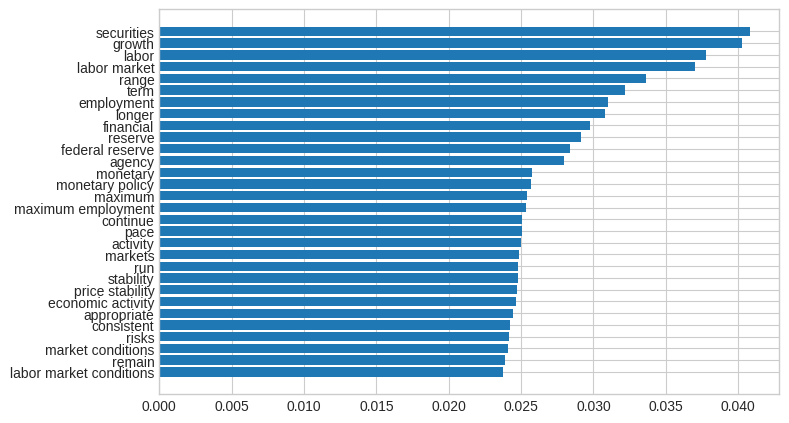

In [9]:
df = pd.DataFrame(X.toarray(), index=statements['text'].index, columns=cols)
bar(df.mean().sort_values(ascending=False).head(30), horizontal=True)

## Principal component exploration

To describe the matrix of tdidf scores, we first perform a simple principal component analysis (`PCA`) with two modes. 

In [10]:
m = PCA(n_components=2).fit(np.log1p(X.toarray().T))
df = pd.DataFrame(m.components_.T, index=statements.index)

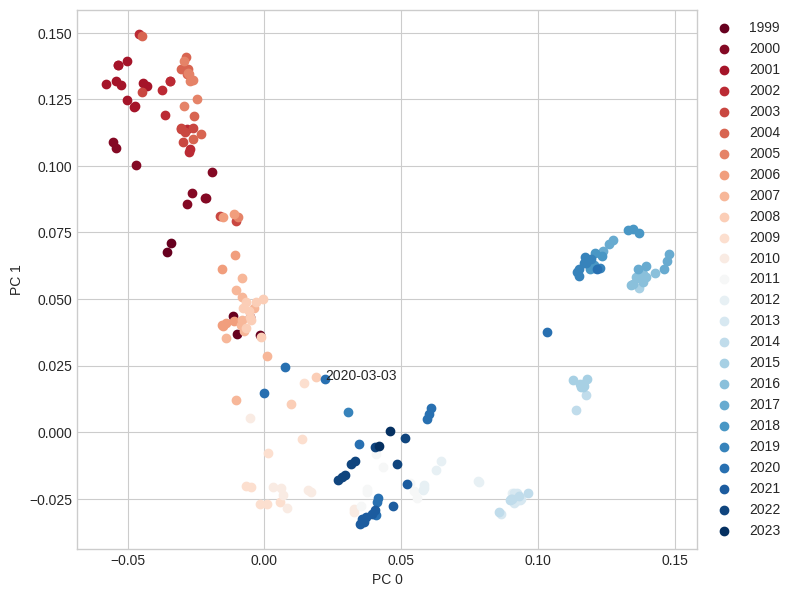

In [11]:
m = PCA(n_components=2).fit(np.log1p(X.toarray().T))
df = pd.DataFrame(m.components_.T, index=statements.index)

fig, ax = plt.subplots(1, 1, figsize=(8, 7))
years = [str(y) for y in df.index.year.unique()]
colors = cm.RdBu(np.linspace(0, 1,len(years)))
for i, y in enumerate(years): 
    ax.scatter(x=df.loc[y][0], y=df.loc[y][1], color=colors[i])
ax.legend(years, loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_xlabel("PC 0")
ax.set_ylabel("PC 1")

d = '2020-03-03'
ax.text(x=df.loc[d][0], y=df.loc[d][1], s=d);

These two modes can be related to labor market and growth. 

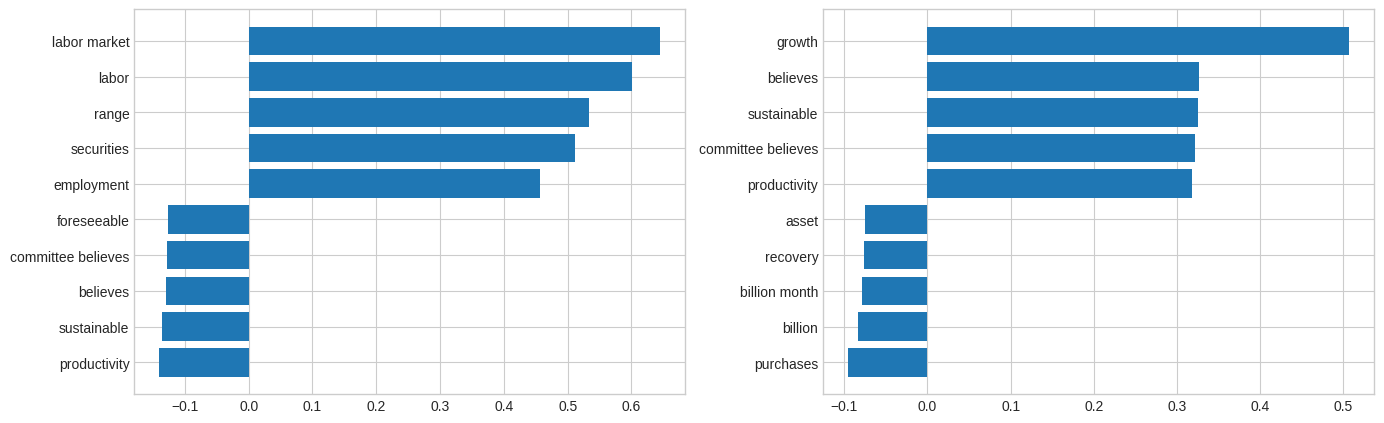

In [12]:
func = lambda x: pd.concat([x.nlargest(), x.sort_values(ascending=False).tail(5)])
W = pd.DataFrame(m.transform(np.log1p(X.toarray().T)), index=cols)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plt.subplots_adjust(wspace=.25)
for i in [0, 1]: 
    bar(W[i].pipe(func), horizontal=True, ax=ax[i])

## Unsupervised learning: document clustering

It is often information to group tokens into topics that explain differences across documents. A powerful algorithm is the non-negative matrix factorisation (`NMF`): for a non-negative matrix $X$ (such as the one with tfidf scores), `NMF` finds two other non-negative matrices such that: 

$$ X \approx W H. $$ 

The number of topics (called `n_components` in the `scikit-learn` implementation) determines the number of columns in $W$ and the number of rows in $H$. 

In [13]:
n_components = 8
m = NMF(n_components=n_components, 
        init='nndsvd', 
        solver='cd', 
        beta_loss='frobenius', 
        random_state=1, 
        alpha_W=0, 
        l1_ratio=0, 
        max_iter=500).fit(X)

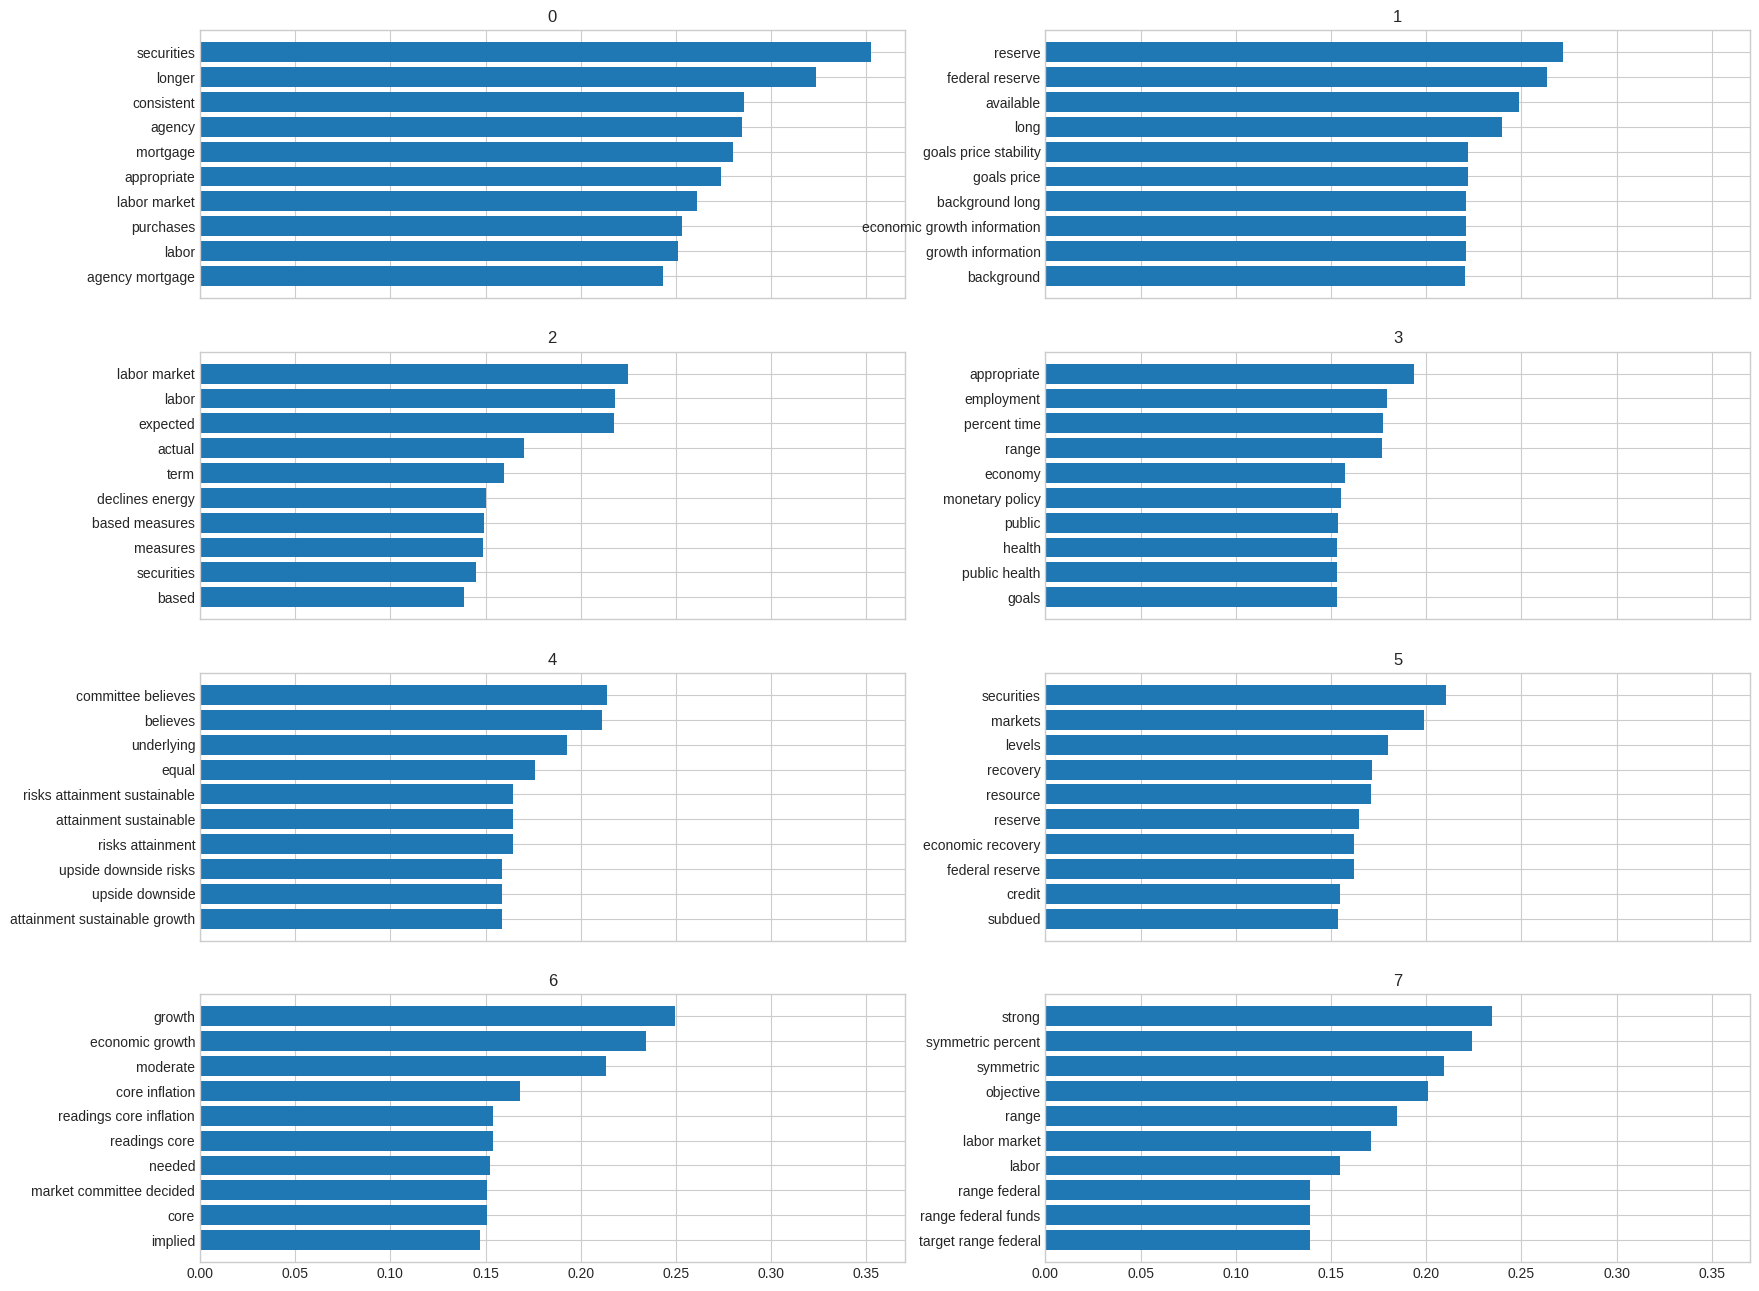

In [14]:
fig, ax = plt.subplots(4, 2, figsize=(20, 16), sharex=True)
ax = ax.ravel()
for i in range(8):
    bar(pd.Series(m.components_[i, :], cols)\
            .sort_values(ascending=False).head(10),
    horizontal=True, ax=ax[i], title=i)

Are these topics interesting? This is a matter of interpretation, but at least, the graph below shows that these topics capture a strong element of time-clustering which makes it a bit less useful.  

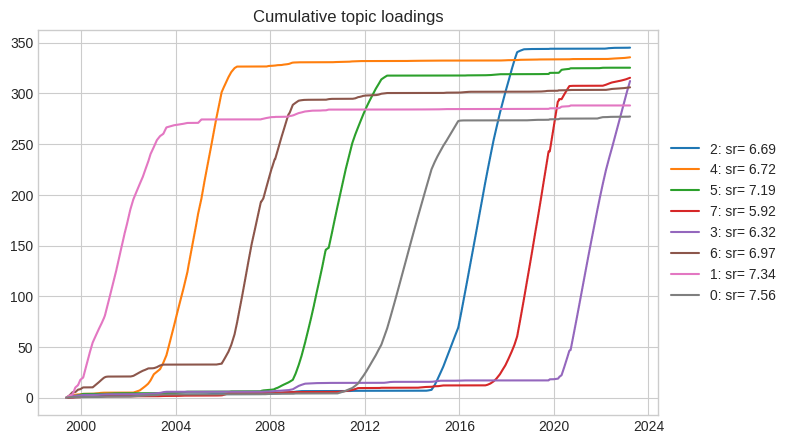

In [15]:
W = pd.DataFrame(m.transform(X), index=df.index)
line(W.resample('B').last().ffill(), cumsum=True, title='Cumulative topic loadings')

## Supervised learning: TFIDF + Elastic net

In this section, we use the corpus of FOMC statements for supervised learning. More precisely, we match the text of the statements to the decision of the committee to raise rates, decrease rates or do nothing.  

In practice, this implemented by using `scikit-learn pipelines` and chaining the `TfidfVectorizer` with a logistic regression. 

In [16]:
import numpy as np 
from skfin.datasets import load_fomc_change_date
fomc_change_up, fomc_change_dw = load_fomc_change_date()

In [17]:
fomc_change_up, fomc_change_dw

(DatetimeIndex(['1999-06-30', '1999-08-24', '1999-11-16', '2000-02-02',
                '2000-03-21', '2000-05-16', '2004-06-30', '2004-08-10',
                '2004-09-21', '2004-11-10', '2004-12-14', '2005-02-02',
                '2005-03-22', '2005-05-03', '2005-06-30', '2005-08-09',
                '2005-09-20', '2005-11-01', '2005-12-13', '2006-01-31',
                '2006-03-28', '2006-05-10', '2006-06-29', '2015-12-16',
                '2016-12-14', '2017-03-15', '2017-06-14', '2017-12-13',
                '2018-03-21', '2018-06-13', '2018-09-26', '2018-12-19',
                '2022-03-16', '2022-05-04', '2022-06-15', '2022-07-27'],
               dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2001-01-03', '2001-01-31', '2001-03-20', '2001-04-18',
                '2001-05-15', '2001-06-27', '2001-08-21', '2001-09-17',
                '2001-10-02', '2001-11-06', '2001-12-11', '2002-11-06',
                '2003-06-25', '2007-09-18', '2007-10-31', '2007-12-11',
            

In [18]:
other = {'other_dt_change': ['2003-01-09', '2008-03-16', '2011-06-22'], 
         'statements_dt_change_other': ['2007-08-16'], 
         'qe1': ['2008-11-25', '2008-12-01', '2008-12-16', '2009-03-18'], 
        'qe2': ['2010-11-03'], 
         'twist': ['2011-09-21', '2012-06-20'],
         'qe3':  ['2012-09-13', '2012-12-12', '2013-12-13'], 
         'corona': ['2020-03-20']
        }

In [19]:
dates = {'up': fomc_change_up, 'dw': fomc_change_dw, 'other': [d for c in other.values() for d in c]}
dates['no change'] = statements.index.difference([d for c in dates.values() for d in c])

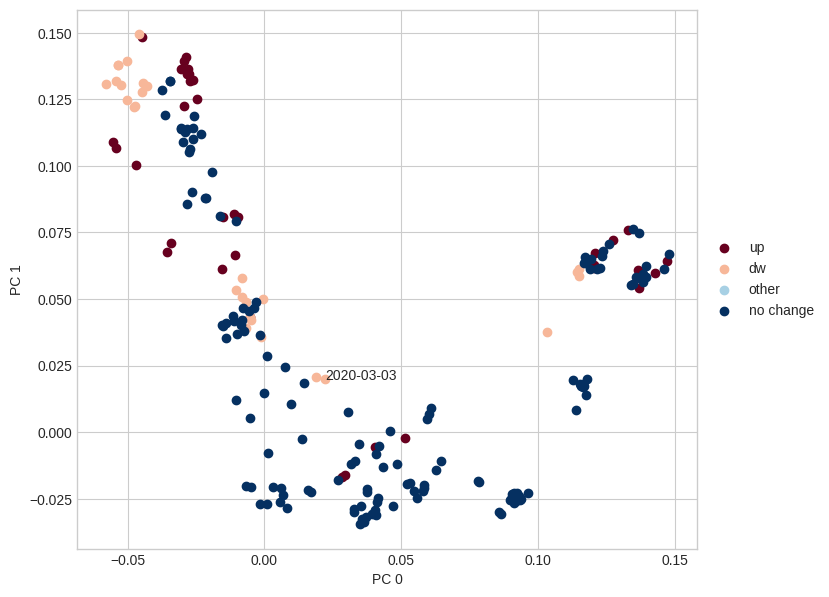

In [20]:
vectorizer = TfidfVectorizer(stop_words='english',
                             min_df=5, max_df=.8, ngram_range=(1, 3),
                             token_pattern=r'\b[a-zA-Z]{3,}\b')
X = vectorizer.fit_transform(statements['text'].values)

m = PCA(n_components=2).fit(np.log1p(X.toarray().T))
df = pd.DataFrame(m.components_.T, index=statements.index)

fig, ax = plt.subplots(1, 1, figsize=(8, 7))
colors = cm.RdBu(np.linspace(0, 1,len(dates)))
for i, (k, v) in enumerate(dates.items()): 
    ax.scatter(x=df.loc[lambda x: x.index.intersection(v)][0], 
               y=df.loc[lambda x: x.index.intersection(v)][1], 
               color=colors[i])
ax.legend(dates.keys(), loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_xlabel("PC 0")
ax.set_ylabel("PC 1")

d = '2020-03-03'
ax.text(x=df.loc[d][0], y=df.loc[d][1], s=d);

In [21]:
from sklearn.linear_model import LogisticRegression, ElasticNet
from skfin.text import coefs_plot, show_text

In [22]:
est = Pipeline([('tfidf', TfidfVectorizer(vocabulary=None,
                                          ngram_range=(1, 3),
                                          max_features=500,
                                          stop_words='english',
                                          token_pattern=r'\b[a-zA-Z]{3,}\b')),
                ('reg', LogisticRegression(C=1, l1_ratio=.35, 
                                           penalty='elasticnet', 
                                           solver='saga', max_iter=500)),
               ])
X, y = pd.concat([statements.loc[fomc_change_up].assign(change=1),
                  statements.loc[fomc_change_dw].assign(change=-1)]).pipe(lambda df: (df['text'], df['change']))
est.fit(X, y);
vocab_ = pd.Series(est.named_steps['tfidf'].vocabulary_).sort_values().index

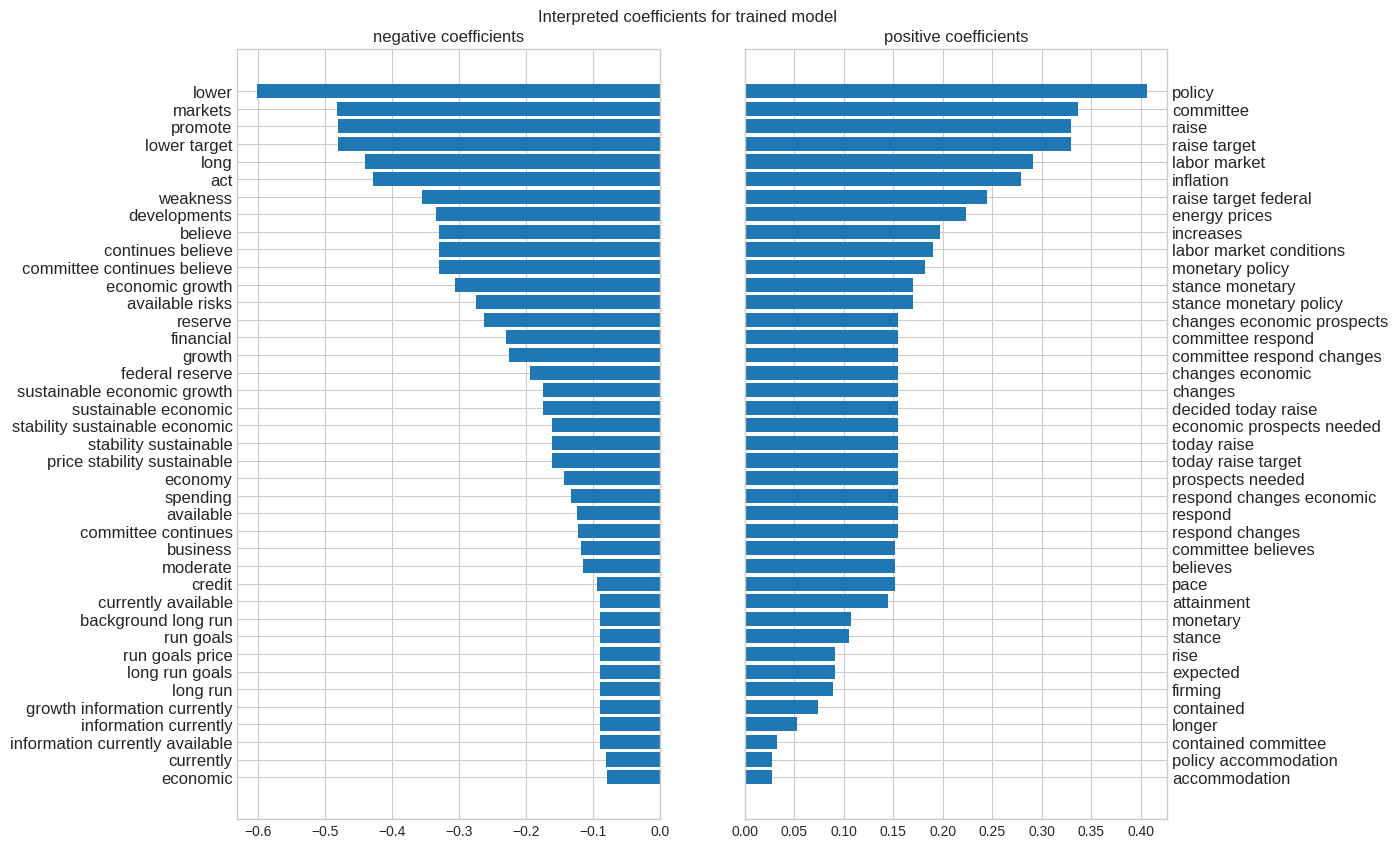

In [23]:
interpret_coef = pd.DataFrame(np.transpose(est.named_steps['reg'].coef_),index=vocab_)
coefs_plot(interpret_coef, title='Interpreted coefficients for trained model')

A trick is that using a linear regression (e.g. ElasticNet) instead of a logistic regression is faster and as efficient (even sometimes better)

In [24]:
est = Pipeline([
('tfidf', TfidfVectorizer(vocabulary=None,
                          ngram_range=(1, 3), 
                          max_features=500,
                          stop_words='english',
                          token_pattern=r'\b[a-zA-Z]{3,}\b')),
    ('reg', ElasticNet(alpha=0.01)),])
X, y = pd.concat([statements.loc[fomc_change_up].assign(change=1),
                  statements.loc[fomc_change_dw].assign(change=-1)]).pipe(lambda df: (df['text'], df['change']))
est.fit(X, y);
vocab_ = pd.Series(est.named_steps['tfidf'].vocabulary_).sort_values().index

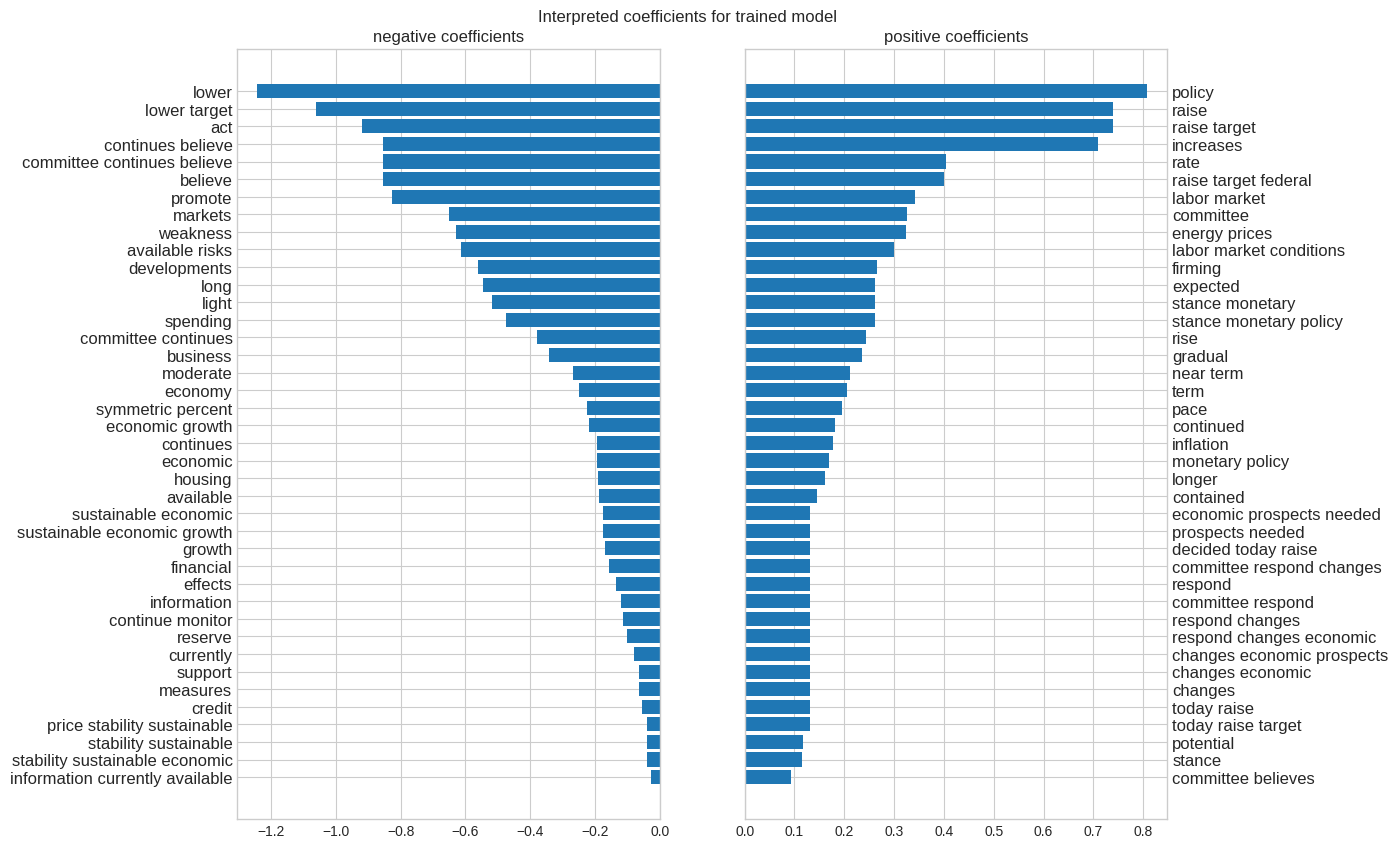

In [25]:
interpret_coef = pd.DataFrame(np.transpose(est.named_steps['reg'].coef_), index=vocab_)
coefs_plot(interpret_coef, title='Interpreted coefficients for trained model')

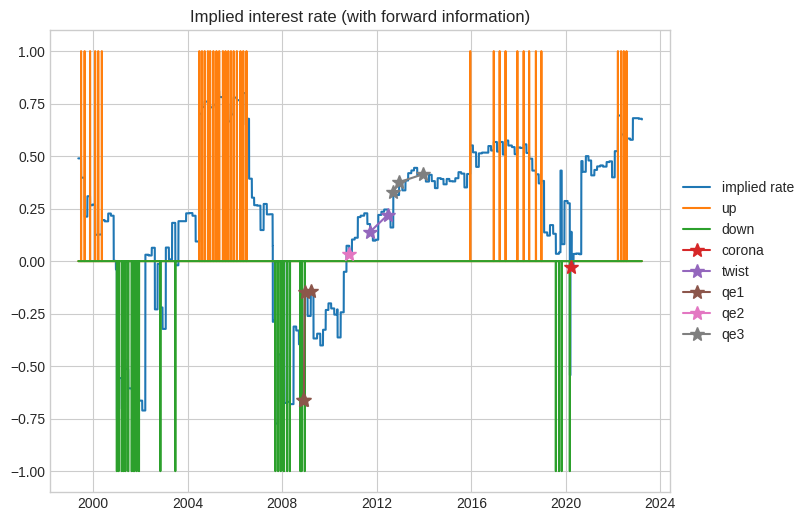

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
pred_tfidf = pd.Series(est.predict(statements['text']), index=statements.index).resample('B').last().ffill()
line(pred_tfidf.rename('implied rate').to_frame()\
        .join(pd.Series(1, index=fomc_change_up).reindex(pred_tfidf.index).fillna(0).rename('up'))\
        .join(pd.Series(-1, index=fomc_change_dw).reindex(pred_tfidf.index).fillna(0).rename('dw')),
sort=False, ax=ax, title='Implied interest rate (with forward information)')
cols = ['corona', 'twist', 'qe1', 'qe2','qe3']
for c in cols:
    ax.plot(pred_tfidf.loc[other[c]], marker='*', ms=10)
ax.legend(['implied rate', 'up', 'down'] + cols, loc='center left', bbox_to_anchor=(1, 0.5));

In [27]:
lexica = {'positive': interpret_coef.squeeze().nlargest(n=10),
          'negative': interpret_coef.squeeze().nsmallest(n=10), }

In [28]:
idx_ = pd.Series(est.predict(X), index=X.index).sort_values().pipe(lambda x: [x.index[0], x.index[-1]])
show_text(statements.loc[idx_], lexica=lexica, n=None)

,last_update,text,voting,release_time,url
release_date,,,,,
2007-09-18,2007-09-18,"The Federal Open Market Committee decided today to lower its target for the federal funds rate 50 basis points to 4-3/4 percent. Economic growth was moderate during the first half of the year, but the tightening of credit conditions has the potential to intensify the housing correction and to restrain economic growth more generally. Todayâs action is intended to help forestall some of the adverse effects on the broader economy that might otherwise arise from the disruptions in financial markets and to promote moderate growth over time. Readings on core inflation have improved modestly this year. However, the Committee judges that some inflation risks remain, and it will continue to monitor inflation developments carefully. Developments in financial markets since the Committeeâs last regular meeting have increased the uncertainty surrounding the economic outlook. The Committee will continue to assess the effects of these and other developments on economic prospects and will act as needed to foster price stability and sustainable economic growth.","Voting for the FOMC monetary policy action were: Ben S. Bernanke, Chairman; Timothy F. Geithner, Vice Chairman; Charles L. Evans; Thomas M. Hoenig; Donald L. Kohn; Randall S. Kroszner; Frederic S. Mishkin; William Poole; Eric Rosengren; and Kevin M. Warsh.",For immediate release,https://www.federalreserve.gov/newsevents/press/monetary/20070918a.htm
2005-03-22,2005-03-22,"The Federal Open Market Committee decided today to raise its target for the federal funds rate by 25 basis points to 2-3/4 percent. The Committee believes that, even after this action, the stance of monetary policy remains accommodative and, coupled with robust underlying growth in productivity, is providing ongoing support to economic activity. Output evidently continues to grow at a solid pace despite the rise in energy prices, and labor market conditions continue to improve gradually. Though longer-term inflation expectations remain well contained, pressures on inflation have picked up in recent months and pricing power is more evident. The rise in energy prices, however, has not notably fed through to core consumer prices. The Committee perceives that, with appropriate monetary policy action, the upside and downside risks to the attainment of both sustainable growth and price stability should be kept roughly equal. With underlying inflation expected to be contained, the Committee believes that policy accommodation can be removed at a pace that is likely to be measured. Nonetheless, the Committee will respond to changes in economic prospects as needed to fulfill its obligation to maintain price stability.","Voting for the FOMC monetary policy action were: Alan Greenspan, Chairman; Timothy F. Geithner, Vice Chairman; Ben S. Bernanke; Susan S. Bies; Roger W. Ferguson, Jr.; Edward M. Gramlich; Jack Guynn; Donald L. Kohn; Michael H. Moskow; Mark W. Olson; Anthony M. Santomero; and Gary H. Stern.",,https://www.federalreserve.gov/boarddocs/press/monetary/2005/20050322/default.htm


## UMAP

Uniform Manifold Approximation and Projection (UMAP) is a popular dimension reduction technique (https://umap-learn.readthedocs.io/en/latest/). 

In [29]:
from umap import UMAP

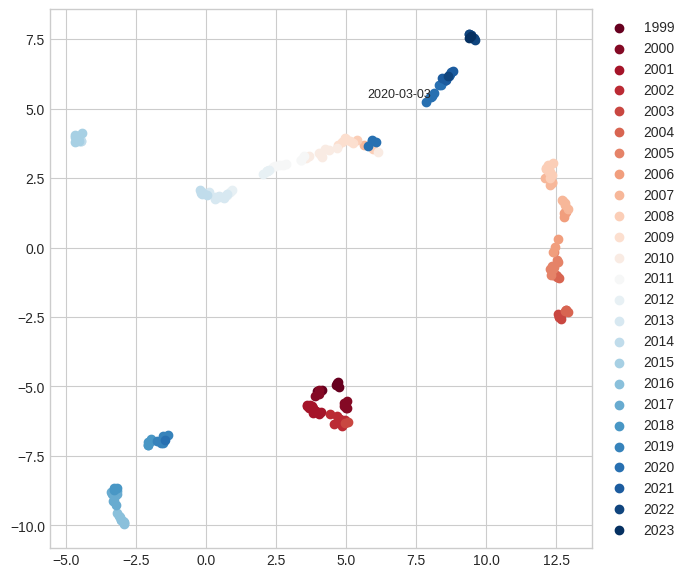

In [30]:
vectorizer = TfidfVectorizer(stop_words='english',
                             min_df=5, max_df=.8, ngram_range=(1, 3),
                             token_pattern=r'\b[a-zA-Z]{3,}\b')
X = vectorizer.fit_transform(statements['text'].values)

Xtfm = UMAP().fit_transform(X)
df = pd.DataFrame(Xtfm, index=statements.index)
classes = df.index.year.unique()

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
colors = cm.RdBu(np.linspace(0, 1, len(classes)))
for i, y in enumerate(classes): 
    ax.scatter(df.loc[str(y)][0], df.loc[str(y)][1], color=colors[i])
ax.legend(classes, loc='center left', bbox_to_anchor=(1, 0.5))

d = '2020-03-03'
ax.text(df.loc[d][0], df.loc[d][1], d, fontsize=9, rotation=0, ha='right');

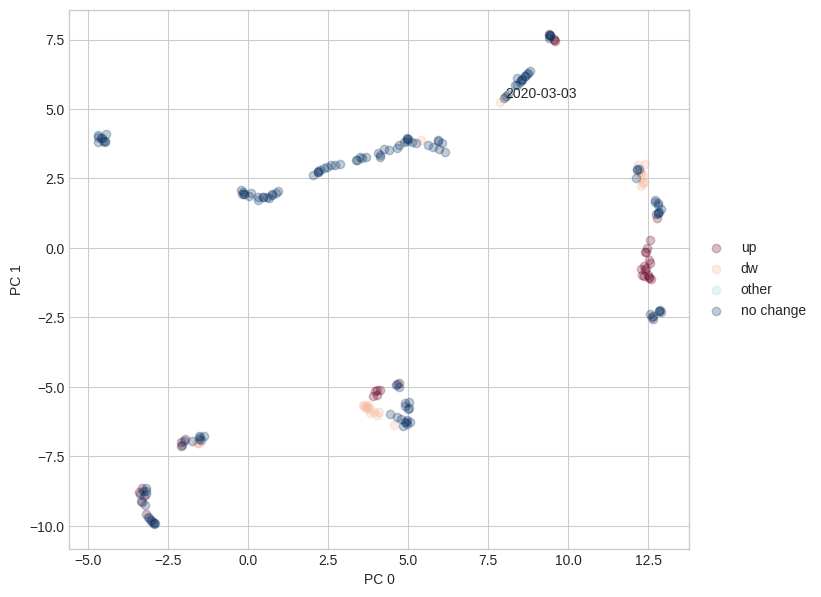

In [31]:
df = pd.DataFrame(Xtfm, index=statements.index)

fig, ax = plt.subplots(1, 1, figsize=(8, 7))
colors = cm.RdBu(np.linspace(0, 1,len(dates)))
for i, (k, v) in enumerate(dates.items()): 
    ax.scatter(x=df.loc[lambda x: x.index.intersection(v)][0], 
               y=df.loc[lambda x: x.index.intersection(v)][1], 
               color=colors[i], alpha=.25)
ax.legend(dates.keys(), loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_xlabel("PC 0")
ax.set_ylabel("PC 1")

d = '2020-03-03'
ax.text(x=df.loc[d][0], y=df.loc[d][1], s=d);

## Sentence transformer

In [32]:
from sentence_transformers import SentenceTransformer

In [33]:
m = SentenceTransformer('all-distilroberta-v1', device='cpu')
X = m.encode(statements['text'].values, batch_size=2)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-distilroberta-v1


Batches:   0%|          | 0/103 [00:00<?, ?it/s]

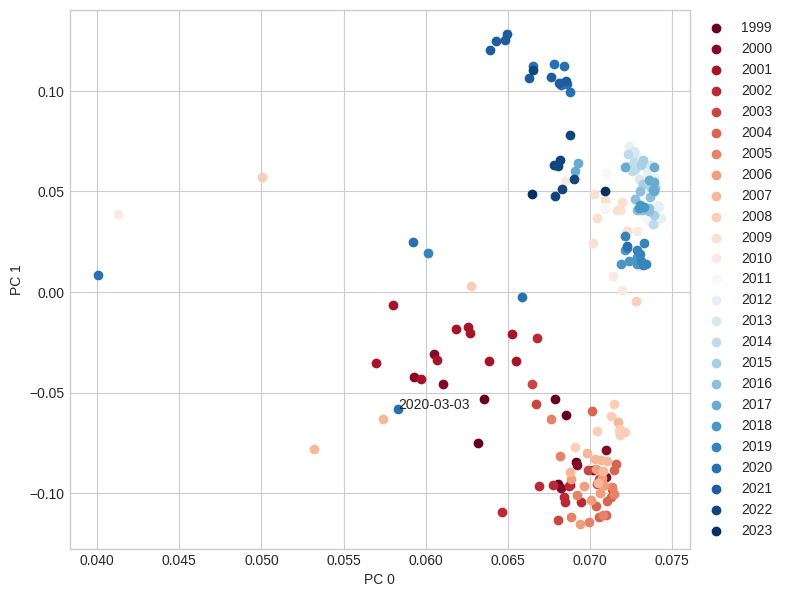

In [34]:
m = PCA(n_components=2).fit(np.log1p(X.T))
df = pd.DataFrame(m.components_.T, index=statements.index)

fig, ax = plt.subplots(1, 1, figsize=(8, 7))
years = [str(y) for y in df.index.year.unique()]
colors = cm.RdBu(np.linspace(0, 1,len(years)))
for i, y in enumerate(years): 
    ax.scatter(x=df.loc[y][0], y=df.loc[y][1], color=colors[i])
ax.legend(years, loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_xlabel("PC 0")
ax.set_ylabel("PC 1")

d = '2020-03-03'
ax.text(x=df.loc[d][0], y=df.loc[d][1], s=d);

In [35]:
Xtfm = UMAP().fit_transform(X)
df_ = pd.DataFrame(Xtfm, index=statements.index)
classes = df.index.year.unique()

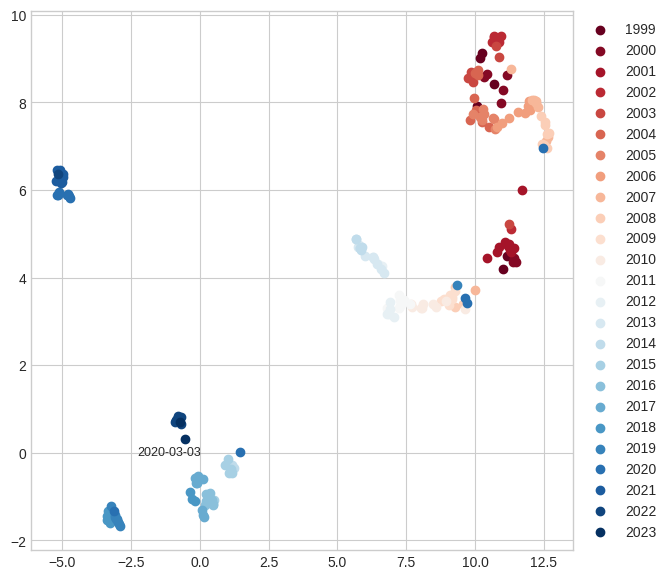

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
colors = cm.RdBu(np.linspace(0, 1, len(classes)))
for i, y in enumerate(classes): 
    ax.scatter(df_.loc[str(y)][0], df_.loc[str(y)][1], color=colors[i])
ax.legend(classes, loc='center left', bbox_to_anchor=(1, 0.5))

d = '2020-03-03'
ax.text(df.loc[d][0], df.loc[d][1], d, fontsize=9, rotation=0, ha='right');

In [37]:
df = pd.DataFrame(X, index=statements.index)
m = ElasticNet(alpha=0.01)
X_, y_ = pd.concat([df.loc[fomc_change_up].assign(change=1),
                  df.loc[fomc_change_dw].assign(change=-1)]).pipe(lambda df: (df.drop('change', axis=1), df['change']))
m.fit(X_, y_);

In [38]:
pred_sbert = pd.Series(m.predict(df), index=statements.index).resample('B').last().ffill()

In [39]:
pd.concat({'sbert': pred_sbert,  'tdfidf': pred_tfidf}, axis=1).corr()

,sbert,tdfidf
sbert,1.000000,0.700731
tdfidf,0.700731,1.000000


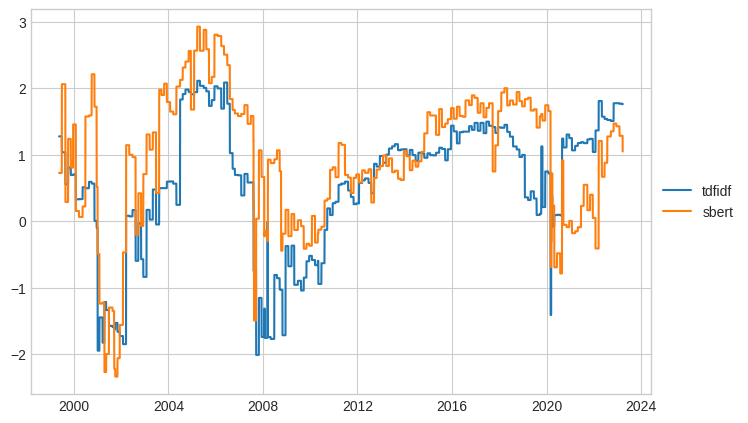

In [40]:
line(pd.concat({'sbert': pred_sbert,  'tdfidf': pred_tfidf}, axis=1).pipe(lambda x:x.div(x.std())))